# Preprocessing

### CONTENTS:

**Chapter 1: Data Preparation and Preprocessing**
- Dataset Acquisition
- Data Exploration and Visualization (EDA)
- Feature Engineering
- Data Cleaning
    - Handling missing values

**Chapter 2: Testing feature correlation**

## 1. Data Preparation and Preprocessing

### 1.1 Dataset Acquisition

In [ ]:
import os
import re
import time
from urllib.request import urlopen

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress FutureWarning for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Constants for the data download and output paths
DATA_URL = "https://www.openml.org/data/download/13153954/speeddating.arff"
CSV_PATH = "data/speed_dating.csv"
PKL_PATH = "data/interim/"
SEED = 37  # For reproducibility

I download the dataset from the internet, save it as a CSV file, and load it into a Pandas DataFrame.

In [25]:
%%time

# Create the destination directory (based on CSV_PATH) if it doesn't exist
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

# Regex pattern to extract the attribute name, handling names with or without single quotes
attribute_pattern = re.compile(
    r"@attribute\s+(?:'(?P<name>[^']+)'|(?P<name_unquoted>\S+))\s+(?P<type>numeric|\{[^}]+\})",
    re.IGNORECASE
)

attributes = []
data_section = False  # Flag to track if we have reached the @data section in the ARFF file
lines_to_write = []   # List to buffer the lines to be written to the CSV file

# Open the URL and process the ARFF file line by line
with urlopen(DATA_URL) as response:
    for raw_line in response:
        decoded_line = raw_line.decode("utf-8").strip()
        lower_line = decoded_line.lower()
        
        # --- HEADER PARSING SECTION ---
        if not data_section:
            # Handle attribute lines
            if lower_line.startswith("@attribute"):
                match = attribute_pattern.match(decoded_line)
                if match:
                    # Extract the name (whether quoted or not) and convert to lowercase
                    attr_name = (match.group("name") or match.group("name_unquoted")).lower()
                    attributes.append(attr_name)
                else:
                    # Fallback: extract the first token after "@attribute" and remove quotes
                    attr_name = decoded_line[len("@attribute"):].strip().split()[0].strip("'\"").lower()
                    attributes.append(attr_name)

            # Handle the start of the data section
            elif lower_line == "@data":
                # Once we find "@data", write the CSV header using the collected attribute names
                lines_to_write.append(",".join(attributes))
                data_section = True
            continue # Move to the next line

        # --- DATA PROCESSING SECTION ---
        # In the data section, process each line for CSV compatibility
        processed_line = (decoded_line
                            .replace("?", "")           # Replace '?' with an empty string (read_csv will interpret this as NaN)
                            .replace("'", ""))          # Remove single quotes
        lines_to_write.append(processed_line.lower())

# Write all buffered lines to the output file in a single operation for efficiency
with open(CSV_PATH, "w", encoding="utf-8") as output_file:
    output_file.write("\n".join(lines_to_write) + "\n")

CPU times: total: 93.8 ms
Wall time: 2.03 s


Load the newly created CSV file into a pandas DataFrame

In [26]:
df = pd.read_csv(CSV_PATH)
# Note: Empty fields ("") are automatically interpreted as NaN by pd.read_csv by default

I exclude from the dataset the columns that wouldn’t be available in my use case.

In [27]:
# Path to the feature selection file
feature_selection_file = "data/features_to_keep.txt"

# Check if the file exists, raise an error if not found
if not os.path.exists(feature_selection_file):
    raise FileNotFoundError(f"File not found: {feature_selection_file}")

# Initialize lists for features to keep and to drop
features_to_keep = []
features_to_drop = []

# Read the file and categorize features based on their flag.
# The expected format for each line is: index \t feature_name \t flag ('y' or 'n')
with open(feature_selection_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 3:
            continue  # Skip any malformed lines
        
        feature = parts[1].strip()
        flag = parts[2].strip().lower()
        
        if flag == "y":
            features_to_keep.append(feature)
        elif flag == "n":
            features_to_drop.append(feature)

# Validate that the features from the file actually exist in the DataFrame's columns
existing_features = set(df.columns)
features_to_drop = [feat for feat in features_to_drop if feat in existing_features]
features_to_keep = [feat for feat in features_to_keep if feat in existing_features]

# Print a summary of the feature selection process
print(f"Total features in DataFrame before drop: {len(df.columns)}")
print(f"Features marked to keep (count {len(features_to_keep)}): {features_to_keep}")
print(f"Features marked to drop (count {len(features_to_drop)}): {features_to_drop}")

# Drop the columns marked with 'n'
if features_to_drop:
    df.drop(columns=features_to_drop, inplace=True)
    print(f"\nDropped {len(features_to_drop)} features.")
else:
    print("\nNo features marked for dropping.")

print(f"Total features in DataFrame after drop: {len(df.columns)}")

Total features in DataFrame before drop: 123
Features marked to keep (count 49): ['wave', 'gender', 'age', 'age_o', 'd_age', 'race', 'race_o', 'samerace', 'importance_same_race', 'importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'interests_correlate', 'expected_happy_with_sd_people', 'expected_num_interested_in_me', 'decision']
Features marked to drop (count 74): ['has_null', 'd_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligenc

I check that, after excluding some columns from the dataset, there are no duplicate rows. If I find any, I remove them.

In [28]:
if df.duplicated().sum() > 0:
    print("There are duplicate rows in the DataFrame. Dropping duplicates...")
    df.drop_duplicates(inplace=True)

There are duplicate rows in the DataFrame. Dropping duplicates...


### 1.2 Data Exploration and Visualization (EDA)

In [29]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8357 entries, 0 to 8377
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wave                           8357 non-null   int64  
 1   gender                         8357 non-null   object 
 2   age                            8270 non-null   float64
 3   age_o                          8266 non-null   float64
 4   d_age                          8357 non-null   int64  
 5   race                           8302 non-null   object 
 6   race_o                         8297 non-null   object 
 7   samerace                       8357 non-null   int64  
 8   importance_same_race           8286 non-null   float64
 9   importance_same_religion       8286 non-null   float64
 10  field                          8302 non-null   object 
 11  pref_o_attractive              8281 non-null   float64
 12  pref_o_sincere                 8281 non-null   float6

In [30]:
print(f"Dataset dimensions: \t{df.shape[0]} instances, {df.shape[1]} features")

numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
num_total_features = len(df.columns)

print(f"Numeric features: \t{len(numeric_features)} / {num_total_features} features ({len(numeric_features)/num_total_features*100:.2f}%)")
print(f"Categorical features: \t{len(categorical_features)} / {num_total_features} features ({len(categorical_features)/num_total_features*100:.2f}%)")

df.head(3)

Dataset dimensions: 	8357 instances, 49 features
Numeric features: 	45 / 49 features (91.84%)
Categorical features: 	4 / 49 features (8.16%)


,wave,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,decision
0,1,female,21.0,27.0,6,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,1
1,1,female,21.0,22.0,1,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,1
2,1,female,21.0,22.0,1,asian/pacific islander/asian-american,asian/pacific islander/asian-american,1,2.0,4.0,...,1.0,10.0,10.0,9.0,8.0,1.0,0.16,3.0,2.0,1


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wave,8357.0,11.358741,5.996174,1.00,7.00,11.00,15.00,21.00
age,8270.0,26.355623,3.564432,18.00,24.00,26.00,28.00,55.00
age_o,8266.0,26.364505,3.561622,18.00,24.00,26.00,28.00,55.00
d_age,8357.0,4.126122,4.439491,0.00,1.00,3.00,5.00,37.00
samerace,8357.0,0.396793,0.489262,0.00,0.00,0.00,1.00,1.00
importance_same_race,8286.0,3.786145,2.846189,0.00,1.00,3.00,6.00,10.00
importance_same_religion,8286.0,3.653633,2.806018,1.00,1.00,3.00,6.00,10.00
pref_o_attractive,8281.0,22.497637,12.574692,0.00,15.00,20.00,25.00,100.00
pref_o_sincere,8281.0,17.396767,7.045262,0.00,15.00,18.37,20.00,60.00
pref_o_intelligence,8281.0,20.274160,6.784474,0.00,17.39,20.00,23.81,50.00


- We notice that the columns `samerace` and `decision` only contain values of 0 or 1, so they should be treated as binary columns.
- We also observe that the `field` attribute has a very high number of unique values (high cardinality).
Given the nature of this attribute, it might be a good idea to group the values into broader categories, since there is a clear and reasonable logic for doing so. This transformation will be applied during the Data Cleaning section.

##### Data Imbalance analysis

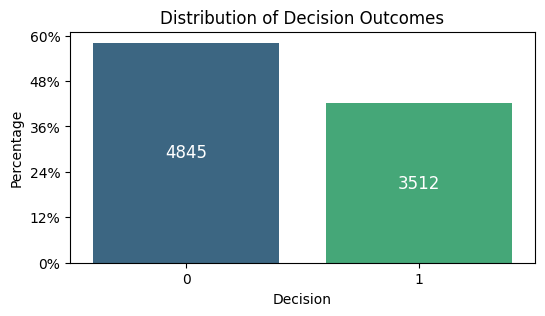

Decision 0: 	freq = 4845, percentage = 57.98%
Decision 1: 	freq = 3512, percentage = 42.02%


In [32]:
import matplotlib.ticker as mtick

plt.figure(figsize=(6, 3))

# Create a count plot for the "decision" column
ax = sns.countplot(data=df, x="decision", palette="viridis")
plt.xlabel("Decision")
plt.ylabel("Percentage")
plt.title("Distribution of Decision Outcomes")

# --- PLOT FORMATTING ---
# Format the y-axis to display percentages instead of raw counts
total = len(df)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))

# Add annotations with the absolute count inside each bar
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2.
    y = height / 2.
    ax.text(x, y, f'{int(height)}', ha='center', va='center', color='white', fontsize=12)

plt.show()

# --- PRINTING EXACT VALUES ---
# Calculate and print the exact frequency and percentage for each decision
decision_freq = df["decision"].value_counts(dropna=False).sort_index()
decision_pct = (df["decision"].value_counts(normalize=True) * 100).sort_index().round(2)

for decision in decision_freq.index:
    print(f"Decision {decision}: \tfreq = {decision_freq[decision]}, percentage = {decision_pct[decision]:.2f}%")

Note: Our target feature does not contain any null values.

#### Check Outliers

Columns with outliers (z > 3):
['age', 'age_o', 'd_age', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'dining', 'museums', 'gaming', 'reading', 'theater', 'movies', 'concerts', 'music', 'interests_correlate', 'expected_num_interested_in_me']
Percentage of numeric features with outliers: 62.22%


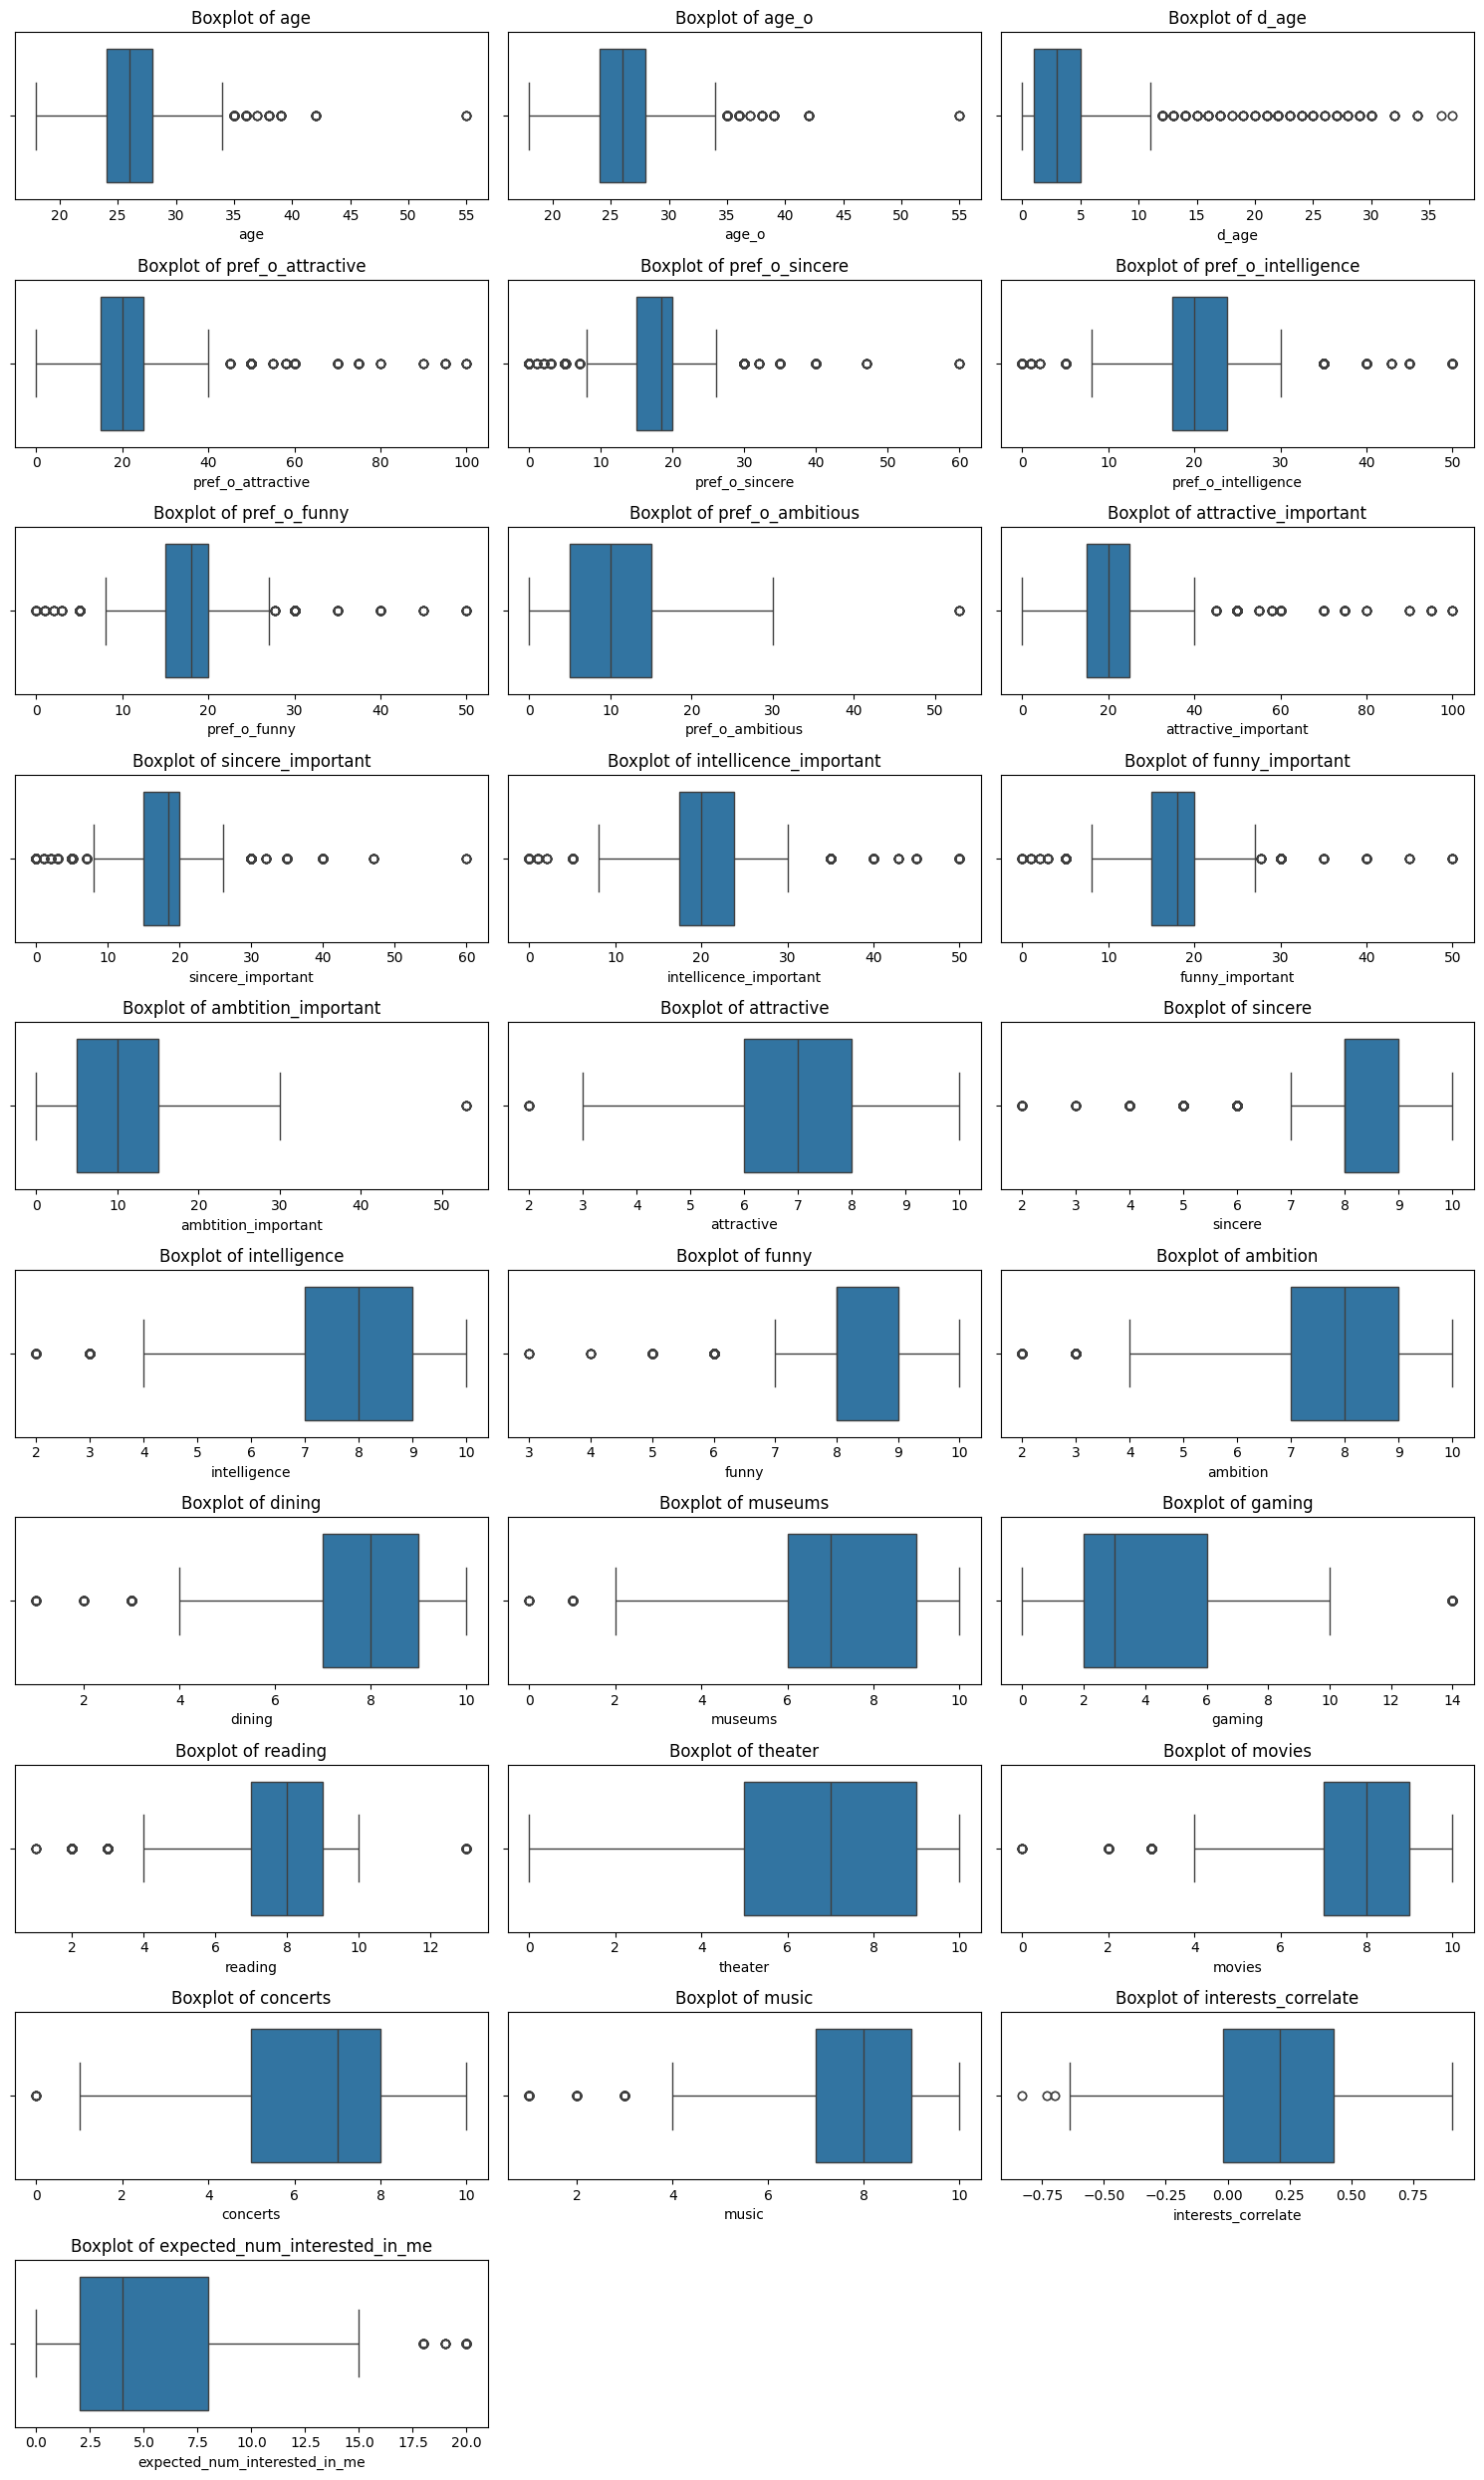

In [33]:
def check_outliers_zscore(df, threshold=3):
    """Identifies numeric columns containing outliers using the Z-score method."""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    outlier_columns = []  # List to store the names of columns with outliers

    for col in numeric_cols:
        values = df[col].values.astype(float)
        mean = np.nanmean(values)
        std = np.nanstd(values)

        if std == 0:  # Avoid division by zero for columns with no variance
            continue

        z_scores = (values - mean) / std

        # Check if any value exceeds the Z-score threshold.
        if np.any(np.abs(z_scores) > threshold):
            outlier_columns.append(col)

    if outlier_columns:
        print(f"Columns with outliers (z > {threshold}):\n{outlier_columns}")
    else:
        print("No outliers found in numeric columns.")

    return outlier_columns



def plot_outlier_boxplots(df, outlier_features):
    """Creates boxplots for a given list of features to visualize their distributions."""
    if not outlier_features:
        print("No features to plot.")
        return

    n = len(outlier_features)
    cols = 3                        # Number of boxplots per row
    rows = (n + cols - 1) // cols   # Calculate the required number of rows

    plt.figure(figsize=(cols * 5, rows * 2.5))

    for i, feature in enumerate(outlier_features, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')
        plt.tight_layout()

    plt.show()


# Detect columns with outliers using the Z-score method
outlier_columns = check_outliers_zscore(df)
print(f"Percentage of numeric features with outliers: {len(outlier_columns) / len(numeric_features) * 100:.2f}%")

# Plot boxplots for the identified columns to visually inspect outliers
plot_outlier_boxplots(df, outlier_columns)

By looking at these boxplots, we can see that many numerical columns contain outliers. However, these unusual values should not be removed. For example, the outliers in the `age` column, where we find users older than the average, still represent real users who would use the application. So, instead of removing them, we should make sure our models are also trained on these data points.

#### Missing value statistics

In [34]:
# Total missing values across the entire DataFrame
total_missing = df.isna().sum().sum()
total_cells = df.size
pct_missing = total_missing / total_cells * 100
print(f"Total missing values: \t\t\t\t{total_missing} / {total_cells} cells \t({pct_missing:.2f}%)")

# Number of rows that have at least one missing value
rows_with_missing = df.isna().any(axis=1).sum()
total_rows = df.shape[0]
pct_rows_missing = rows_with_missing / total_rows * 100
print(f"Rows with at least one missing value: \t\t{rows_with_missing} / {total_rows} rows \t({pct_rows_missing:.2f}%)\n")

# Number of features (columns) with at least one missing value
cols_with_missing = df.isna().any().sum()
total_cols = df.shape[1]
pct_cols_missing = cols_with_missing / total_cols * 100
print(f"Features with at least one missing value: \t{cols_with_missing} / {total_cols} features \t({pct_cols_missing:.2f}%)")

# Number of features where all values are missing
cols_all_missing = df.isna().all().sum()
pct_cols_all_missing = cols_all_missing / total_cols * 100
print(f"Features with all values missing: \t\t{cols_all_missing} / {total_cols} features \t({pct_cols_all_missing:.2f}%)\n")

# Calculate missing counts for each feature (column)
missing_counts = df.isna().sum()
# Filter out features with no missing values (i.e. count == 0)
missing_counts_nonzero = missing_counts[missing_counts > 0]

# Print the top 3 features with the most missing values
print("Top 3 features with the most missing values:")
top_features = missing_counts_nonzero.nlargest(3)
for feature, count in top_features.items():
    print(f"\t{feature:<30}\t: {count}")

# Print the the 3 features with the fewest (but non-zero) missing values.
print("\nBottom 3 features with missing values (non-zero):")
bottom_features = missing_counts_nonzero.nsmallest(3)
for feature, count in bottom_features.items():
    print(f"\t{feature:<30}\t: {count}")

# Print the names of features with no missing values on a single line.
print("\nFeatures with no missing values:")
missing_counts_zero = missing_counts[missing_counts == 0]
print('\t' + ", ".join(missing_counts_zero.index))

# Calculate the distribution of missing value counts per row.
nan_counts_per_row = df.isna().sum(axis=1)
counts = nan_counts_per_row.value_counts().sort_index()
percentages = (counts / df.shape[0] * 100).round(2)

print("\nTable: Number of NaNs per Row vs. Frequency")
pd.DataFrame({'Rows with this amount of NaNs': counts, 'Percentage': percentages})


Total missing values: 				9995 / 409493 cells 	(2.44%)
Rows with at least one missing value: 		6637 / 8357 rows 	(79.42%)

Features with at least one missing value: 	44 / 49 features 	(89.80%)
Features with all values missing: 		0 / 49 features 	(0.00%)

Top 3 features with the most missing values:
	expected_num_interested_in_me 	: 6562
	interests_correlate           	: 137
	pref_o_shared_interests       	: 116

Bottom 3 features with missing values (non-zero):
	race                          	: 55
	field                         	: 55
	race_o                        	: 60

Features with no missing values:
	wave, gender, d_age, samerace, decision

Table: Number of NaNs per Row vs. Frequency


,Rows with this amount of NaNs,Percentage
0,1720,20.58
1,6340,75.86
2,66,0.79
3,56,0.67
4,2,0.02
6,26,0.31
7,16,0.19
8,8,0.10
9,15,0.18
10,35,0.42


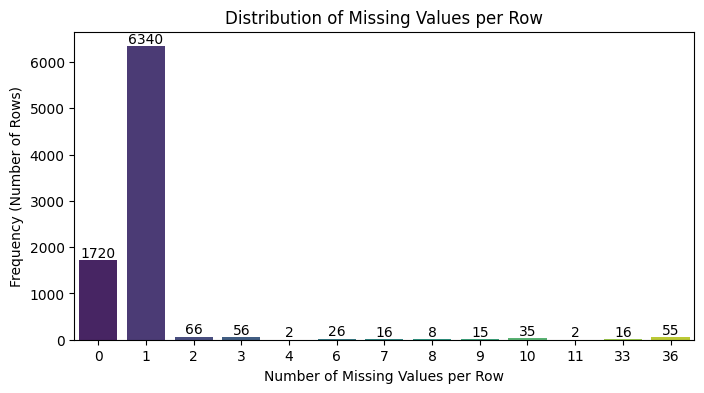

In [35]:
# Calculate the frequency distribution of NaN counts per row.
nan_counts = df.isna().sum(axis=1)
freq = nan_counts.value_counts().sort_index()

# Create a bar plot to visualize the distribution.
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=freq.index, y=freq.values, palette='viridis')

plt.xlabel("Number of Missing Values per Row")
plt.ylabel("Frequency (Number of Rows)")
plt.title("Distribution of Missing Values per Row")

# Annotate each bar with its absolute frequency.
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

plt.show()

#### Data Visualization
Now we’ll perform some visual analysis of the data to better understand the characteristics of the dataset and the relationships between variables.

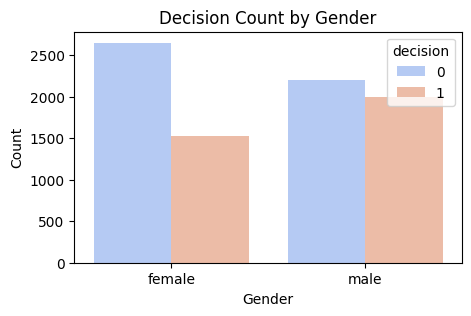

In [36]:
# This plot examines the distribution of date outcomes ('decision') broken down by gender.
# It's useful for seeing if there's a gender imbalance in the dataset or in who says 'yes'.
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='gender', hue='decision', palette='coolwarm')
plt.title('Decision Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

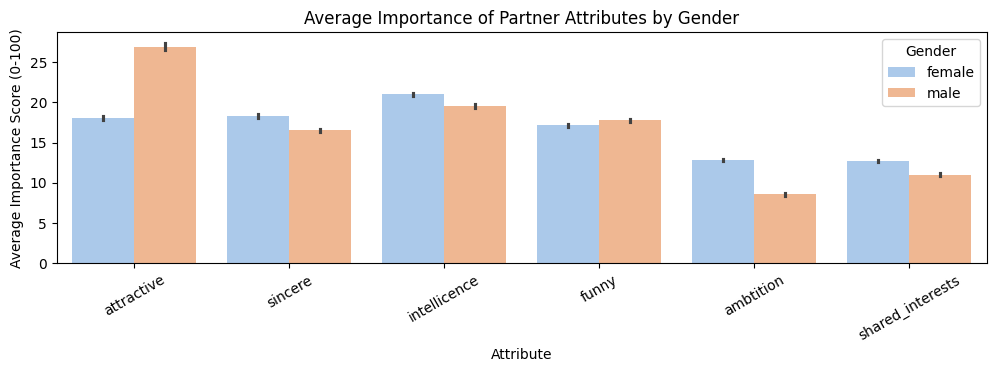

In [37]:
# This plot compares what men and women state as important in a partner before the date.
# It helps to identify if different genders prioritize attributes differently.
my_partner_preferences = ["attractive_important", "sincere_important", "intellicence_important", "funny_important", "ambtition_important", "shared_interests_important"]

# Melt the DataFrame to a "long" format for easier plotting with Seaborn.
df_melted_prefs = df.melt(id_vars=['gender'], value_vars=my_partner_preferences, 
                          var_name='preference_type', value_name='importance_score')

# Clean up attribute names for better plot labels.
df_melted_prefs['preference_type'] = df_melted_prefs['preference_type'].str.replace('_important', '')

plt.figure(figsize=(12, 3))
sns.barplot(data=df_melted_prefs, x='preference_type', y='importance_score', hue='gender', palette='pastel')
plt.title('Average Importance of Partner Attributes by Gender')
plt.xlabel('Attribute')
plt.ylabel('Average Importance Score (0-100)')
plt.xticks(rotation=30)
plt.legend(title='Gender')
plt.show()

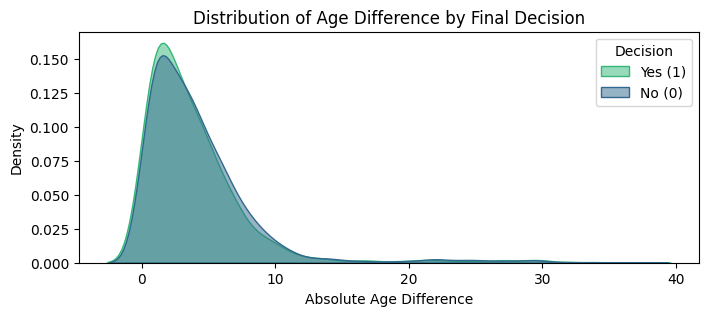

In [38]:
# --- Does Age Difference Matter? ---

# Create a Kernel Density Plot (KDE) to visualize the distribution of age differences.
# 'hue' separates the distributions for 'yes' (1) and 'no' (0) decisions.
plt.figure(figsize=(8, 3))
sns.kdeplot(data=df, x='d_age', hue='decision', fill=True, 
            common_norm=False, palette='viridis', alpha=0.5)
plt.title('Distribution of Age Difference by Final Decision')
plt.xlabel('Absolute Age Difference')
plt.ylabel('Density')
plt.legend(title='Decision', labels=['Yes (1)', 'No (0)'])
plt.show()

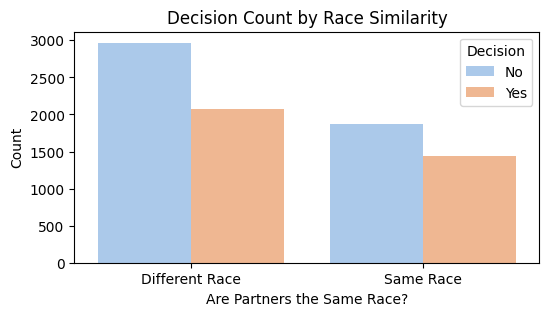

In [39]:
# --- Impact of 'Same Race' on Decision ---

# Create a count plot to compare outcomes when partners are of the same race vs. different races.
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='samerace', hue='decision', palette='pastel')

# Add labels for clarity.
plt.title('Decision Count by Race Similarity')
plt.xlabel('Are Partners the Same Race?')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Different Race', 'Same Race'])
plt.legend(title='Decision', labels=['No', 'Yes'])
plt.show()

### 1.3 Feature Engineering

As discussed earlier, the `field` attribute has a very high number of unique values (high cardinality). For this reason, I group them into more general categories.

In [40]:
print(f"Before transformation, 'field' has {df.field.nunique(dropna=True)} unique values")
print("(plus NaN values)")

Before transformation, 'field' has 219 unique values
(plus NaN values)


In [ ]:
def map_field_to_category(field):
    """Maps a specific field of study string to a broad category."""

    # Handle missing or invalid data by returning a standard NaN object.
    if pd.isna(field) or not isinstance(field, str) or field.lower() == 'nan':
        return np.nan

    clean_field = field.lower()

    # Proceed with keyword-based mapping for valid strings.
    if 'law' in clean_field or 'j.d.' in clean_field:
        return 'Law'
    
    if any(keyword in clean_field for keyword in [
        'business', 'mba', 'financ', 'market', 'consulting', 
        'management', 'real estate', 'fundraising', 'money', 'finanace' # Typo
    ]):
        return 'Business'

    if any(keyword in clean_field for keyword in [
        'international affairs', 'sipa', 'public administration', 'public policy',
        'human rights', 'international development', 'international security',
        'international politics', 'international relations', 'intrernational affairs' # Typo
    ]):
        return 'PublicAffairs'
        
    if any(keyword in clean_field for keyword in [
        'medicine', 'medical', 'health', 'biomedical', 'epidemiology', 'nutriti', # 'nutriti' catches 'nutrition' and 'nutritiron'
        'clinical psychology', 'counseling psychology', 'social work', 'speech', 'pathology',
        'premed', 'sociomedical'
    ]):
        return 'Health'

    if any(keyword in clean_field for keyword in [
        'education', 'teaching', 'ed.d', ' tc ', 'literacy', 'school psychology',
        'curriculum', 'tesol', 'bilingual', 'instructional', 'higher ed'
    ]):
        return 'Education'

    if any(keyword in clean_field for keyword in [
        'engineering', 'engg', 'computer science', 'informatics', 'math', 'statistics',
        'stats', 'quantitative methods', 'qmss', 'biology', 'chemistry', 'physics',
        'biochem', 'biophysics', 'neuro', 'genetics', 'ecology', 'climate', 'earth',
        'environmental science', 'conservation', 'biotechnology', 'operations research',
        'geophysics'
    ]):
        return 'STEM'

    if any(keyword in clean_field for keyword in [
        'art', 'acting', 'film', 'writing', 'poetry', 'literature', 'english',
        'history', 'classics', 'philosophy', 'religion', 'music', 'theater', 'theatre',
        'communications', 'journalism', 'french', 'german', 'japanese', 'polish', 'mfa',
        'architecture', 'gsas'
    ]):
        return 'ArtsHumanities'

    if any(keyword in clean_field for keyword in [
        'sociology', 'anthropology', 'economics', 'political science', 'psychology',
        'urban planning', 'american studies'
    ]):
        return 'SocialScience'

    if any(keyword in clean_field for keyword in ['working', 'undergrad - gs', 'theory']):
        return 'Other'

    # If no keywords match, categorize as 'Other'.
    return 'Other'


# Apply the mapping function to the 'field' column to consolidate its values.
df['field'] = df['field'].apply(map_field_to_category)

In [42]:
print(f"\nAfter transformation, 'field' has {df.field.nunique(dropna=True)} unique values")
print("(plus NaN values)")

# Display the distribution of the newly created categories.
print("\nThe new distribution of values is:")
df.field.value_counts(dropna=False).sort_index()


After transformation, 'field' has 9 unique values
(plus NaN values)

The new distribution of values is:


field
ArtsHumanities     893
Business          1840
Education          744
Health            1116
Law                674
Other               39
PublicAffairs      623
STEM              1723
SocialScience      650
NaN                 55
Name: count, dtype: int64

#### Data Correction
We check whether the features in the dataset contain only values that fall within the expected range for each specific feature, as reported in the documentation attached to this study.

feature group: Activity features

In [43]:
# List of columns representing interest in activities, expected to be on a 1-10 scale.
activity_columns = [
    'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 
    'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 
    'movies', 'concerts', 'music', 'shopping', 'yoga'
]

# Iterate through each activity column to check if its values are within the expected [0, 10] range.
for col in activity_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val < 0 or max_val > 10:
        print(f"ERROR \t'{col}' has values outside [0,10]: min = {min_val}, max = {max_val}")
    else:
        print(f"OK \t'{col}' is within [0,10]: min = {min_val}, max = {max_val}")

OK 	'sports' is within [0,10]: min = 1.0, max = 10.0
OK 	'tvsports' is within [0,10]: min = 1.0, max = 10.0
OK 	'exercise' is within [0,10]: min = 1.0, max = 10.0
OK 	'dining' is within [0,10]: min = 1.0, max = 10.0
OK 	'museums' is within [0,10]: min = 0.0, max = 10.0
OK 	'art' is within [0,10]: min = 0.0, max = 10.0
OK 	'hiking' is within [0,10]: min = 0.0, max = 10.0
ERROR 	'gaming' has values outside [0,10]: min = 0.0, max = 14.0
OK 	'clubbing' is within [0,10]: min = 0.0, max = 10.0
ERROR 	'reading' has values outside [0,10]: min = 1.0, max = 13.0
OK 	'tv' is within [0,10]: min = 1.0, max = 10.0
OK 	'theater' is within [0,10]: min = 0.0, max = 10.0
OK 	'movies' is within [0,10]: min = 0.0, max = 10.0
OK 	'concerts' is within [0,10]: min = 0.0, max = 10.0
OK 	'music' is within [0,10]: min = 1.0, max = 10.0
OK 	'shopping' is within [0,10]: min = 1.0, max = 10.0
OK 	'yoga' is within [0,10]: min = 0.0, max = 10.0


We then discover that the columns `gaming` and `reading` contain invalid values.

In [44]:
# Display the value counts for the 'gaming' column to inspect its distribution.
print(df.gaming.value_counts().sort_index())

# Calculate the count and percentage of rows where 'gaming' is outside the [0, 10] range.
gaming_outliers = df[(df.gaming < 0) | (df.gaming > 10)]
gaming_outliers_count = gaming_outliers.shape[0]
gaming_outliers_pct = gaming_outliers_count / df.shape[0] * 100
print(f"\nOutliers in 'gaming': {gaming_outliers_count} / {df.shape[0]} rows ({gaming_outliers_pct:.2f}%)")

gaming
0.0       59
1.0     1980
2.0     1173
3.0     1075
4.0      709
5.0     1024
6.0      759
7.0      733
8.0      429
9.0      220
10.0      47
14.0      78
Name: count, dtype: int64

Outliers in 'gaming': 78 / 8357 rows (0.93%)


In [45]:
# Display the value counts for the 'reading' column.
print(df.reading.value_counts().sort_index())

# Calculate the count and percentage of rows where 'reading' is outside the [0, 10] range.
reading_outliers = df[(df.reading < 0) | (df.reading > 10)]
reading_outliers_count = reading_outliers.shape[0]
reading_outliers_pct = reading_outliers_count / df.shape[0] * 100
print(f"\nOutliers in 'reading': {reading_outliers_count} / {df.shape[0]} rows ({reading_outliers_pct:.2f}%)")

reading
1.0       10
2.0      161
3.0      246
4.0      222
5.0      571
6.0      767
7.0     1271
8.0     1616
9.0     1997
10.0    1374
13.0      51
Name: count, dtype: int64

Outliers in 'reading': 51 / 8357 rows (0.61%)


Both columns contain a very small number of invalid values, which suggests they are likely just typing errors. So, we decide to fix them by replacing these values with the median. Since we already noticed the presence of outliers in these two columns, it makes more sense to use the median of the valid values rather than the mean.

In [46]:
# For 'gaming' and 'reading' columns, values > 10 are considered outliers.
# These outliers will be replaced by the median calculated only from the valid values (<= 10).
gaming_median = df.loc[df.gaming <= 10, 'gaming'].median()
reading_median = df.loc[df.reading <= 10, 'reading'].median()

df.loc[df.gaming > 10, 'gaming'] = gaming_median
df.loc[df.reading > 10, 'reading'] = reading_median

feature group: Self_ratings features

In [47]:
# Check if self-rating columns are within the expected [0, 10] range.
self_ratings_columns = ["attractive", "sincere", "intelligence", "funny", "ambition"]

for col in self_ratings_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val < 0 or max_val > 10:
        print(f"ERROR \t'{col}' has values outside [0,10]: min = {min_val}, max = {max_val}")
    else:
        print(f"OK \t'{col}' is within [0,10]: min = {min_val}, max = {max_val}")

OK 	'attractive' is within [0,10]: min = 2.0, max = 10.0
OK 	'sincere' is within [0,10]: min = 2.0, max = 10.0
OK 	'intelligence' is within [0,10]: min = 2.0, max = 10.0
OK 	'funny' is within [0,10]: min = 3.0, max = 10.0
OK 	'ambition' is within [0,10]: min = 2.0, max = 10.0


feature group: My_Partner_Preferences features

In [48]:
# Check if personal preference importance columns are within the expected [1, 100] range.
my_partner_preferences = ["attractive_important", "sincere_important", "intellicence_important", "funny_important", "ambtition_important", "shared_interests_important"]

for col in my_partner_preferences:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val < 0 or max_val > 100:
        print(f"ERROR \t'{col}' has values outside [1,100]: min = {min_val}, max = {max_val}")
    else:
        print(f"OK \t'{col}' is within [1,100]: min = {min_val}, max = {max_val}")

OK 	'attractive_important' is within [1,100]: min = 0.0, max = 100.0
OK 	'sincere_important' is within [1,100]: min = 0.0, max = 60.0
OK 	'intellicence_important' is within [1,100]: min = 0.0, max = 50.0
OK 	'funny_important' is within [1,100]: min = 0.0, max = 50.0
OK 	'ambtition_important' is within [1,100]: min = 0.0, max = 53.0
OK 	'shared_interests_important' is within [1,100]: min = 0.0, max = 30.0


feature group: Partner_Seeking_Preferences features

In [49]:
# Check if preferences for what a partner seeks are within the expected [1, 100] range.
partner_seeking_preferences = ["pref_o_attractive", "pref_o_sincere", "pref_o_intelligence", "pref_o_funny", "pref_o_ambitious", "pref_o_shared_interests"]
for col in partner_seeking_preferences:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val < 0 or max_val > 100:
        print(f"ERROR \t'{col}' has values outside [1,100]: min = {min_val}, max = {max_val}")
    else:
        print(f"OK \t'{col}' is within [1,100]: min = {min_val}, max = {max_val}")

OK 	'pref_o_attractive' is within [1,100]: min = 0.0, max = 100.0
OK 	'pref_o_sincere' is within [1,100]: min = 0.0, max = 60.0
OK 	'pref_o_intelligence' is within [1,100]: min = 0.0, max = 50.0
OK 	'pref_o_funny' is within [1,100]: min = 0.0, max = 50.0
OK 	'pref_o_ambitious' is within [1,100]: min = 0.0, max = 53.0
OK 	'pref_o_shared_interests' is within [1,100]: min = 0.0, max = 30.0


The **Speed Dating Data Key** document, which explains the dataset's features, states that the preference ratings in Waves 6-9 were collected on a 1-10 scale, while other waves used a 100-point distribution system. <br>
This implies a need for normalization. To verify this, we will first analyze the two groups of waves separately.

In [50]:
# Split the DataFrame into two groups: Waves 6-9 and all other waves.
df_waves_69 = df[df.wave.isin([6, 7, 8, 9])].copy()
df_other_waves = df[~df.wave.isin([6, 7, 8, 9])].copy()

In [51]:
# --- ANALYSIS OF WAVES OTHER THAN 6-9 ---

# Calculate the sum of preference scores for each participant in the first group.
df_other_waves["importance_sum"] = df_other_waves[my_partner_preferences].sum(axis=1)
print("Distribution of preference sums for Waves != 6,7,8,9:")
print(df_other_waves["importance_sum"].value_counts(dropna=False).sort_index(), "\n")

# Checking for NaN
# Counting NaN here doesn’t make sense because the sum of NaNs is 0, so it’s not possible to have NaN as a final value.

# Count how many sums are approximately 100 (within a small tolerance for rounding).
total = df_other_waves.shape[0]
equal_100 = df_other_waves[
    (df_other_waves["importance_sum"] >= 99.95) & 
    (df_other_waves["importance_sum"] <= 100.05)
].shape[0]
not_equal_100 = total - equal_100
pct_equal_100 = equal_100 / total * 100
pct_not_equal_100 = not_equal_100 / total * 100
print(f"Sum of importances equal to 100: \t{equal_100} / {total} rows \t({pct_equal_100:.2f}%)")
print(f"Sum of importances not equal to 100: \t{not_equal_100} / {total} rows \t({pct_not_equal_100:.2f}%)")

print(f"\nShape of the df_other_waves: {df_other_waves.shape}")
# Note: No need to drop 'importance_sum' as we are working on a copy of the original DataFrame.

Distribution of preference sums for Waves != 6,7,8,9:
importance_sum
0.00        66
90.00       64
95.00       22
99.99       10
99.99       30
100.00    6482
100.01      14
100.01      20
100.02      21
101.00       9
110.00      22
120.00      25
148.00      10
Name: count, dtype: int64 

Sum of importances equal to 100: 	6577 / 6795 rows 	(96.79%)
Sum of importances not equal to 100: 	218 / 6795 rows 	(3.21%)

Shape of the df_other_waves: (6795, 50)


In [52]:
df_other_waves.loc[df_other_waves["importance_sum"] == 110, my_partner_preferences + ["importance_sum"]].head(3)

,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,importance_sum
7608,20.0,25.0,25.0,30.0,5.0,5.0,110.0
7609,20.0,25.0,25.0,30.0,5.0,5.0,110.0
7610,20.0,25.0,25.0,30.0,5.0,5.0,110.0


In [53]:
df_other_waves.loc[df_other_waves["importance_sum"] == 120, my_partner_preferences + ["importance_sum"]].head(3)

,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,importance_sum
580,25.0,15.0,25.0,25.0,15.0,15.0,120.0
581,25.0,15.0,25.0,25.0,15.0,15.0,120.0
582,25.0,15.0,25.0,25.0,15.0,15.0,120.0


In [54]:
df_other_waves.loc[df_other_waves["importance_sum"] == 148, my_partner_preferences + ["importance_sum"]].head(3)

,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,importance_sum
908,20.0,25.0,15.0,15.0,53.0,20.0,148.0
909,20.0,25.0,15.0,15.0,53.0,20.0,148.0
910,20.0,25.0,15.0,15.0,53.0,20.0,148.0


In [55]:
# --- ANALYSIS OF WAVES 6-9 ---

# Now, repeat the same analysis for Waves 6-9.
df_waves_69["importance_sum"] = df_waves_69[my_partner_preferences].sum(axis=1)
print("\nDistribution of preference sums for Waves == 6,7,8,9:")
print(df_waves_69["importance_sum"].value_counts(dropna=False).sort_index(), "\n")

# Count how many sums are approximately 100 in the Waves 6-9 group.
total = df_waves_69.shape[0]
equal_100 = df_waves_69[
    (df_waves_69["importance_sum"] >= 99.95) & 
    (df_waves_69["importance_sum"] <= 100.05)
].shape[0]
not_equal_100 = total - equal_100
pct_equal_100 = equal_100 / total * 100
pct_not_equal_100 = not_equal_100 / total * 100
print(f"Sum of importances equal to 100: \t{equal_100} / {total} rows \t({pct_equal_100:.2f}%)")
print(f"Sum of importances not equal to 100: \t{not_equal_100} / {total} rows \t({pct_not_equal_100:.2f}%)")

print(f"\nShape of the df_waves_69: {df_waves_69.shape}")
# Note: No need to drop 'importance_sum' as we are working on a copy.


Distribution of preference sums for Waves == 6,7,8,9:
importance_sum
0.00        5
99.98      26
99.99      16
99.99      72
99.99     169
100.00     56
100.00    649
100.00    110
100.01    113
100.01    219
100.02     56
100.02     71
Name: count, dtype: int64 

Sum of importances equal to 100: 	1557 / 1562 rows 	(99.68%)
Sum of importances not equal to 100: 	5 / 1562 rows 	(0.32%)

Shape of the df_waves_69: (1562, 50)


In [56]:
df_waves_69.loc[df_waves_69["importance_sum"] != 0.0, my_partner_preferences + ["importance_sum"]].head(3)

,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,importance_sum
1846,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1847,16.67,16.67,16.67,16.67,16.67,16.67,100.02
1848,16.67,16.67,16.67,16.67,16.67,16.67,100.02


We notice that, contrary to what is stated in the aforementioned document, all the values in the `preferences` columns have already been converted into percentages by the dataset creators, based on the raw data from the study.

However, in some rows, the total percentage does not exactly sum to 100.
- In most cases, the discrepancy is due to rounding errors.
- In rows where the total is 110 or 120, the values appear consistent and will be normalized.
- A different approach is needed for rows where the total is 148, as these are likely typographical errors. We will set these values to NaN to be handled later.

In [57]:
# If, for a row, the sum of the features in my_partner_preferences is 148,
# set all the values in those columns to NaN for that row.
mask_my = df[my_partner_preferences].sum(axis=1) == 148
num_my = mask_my.sum()
df.loc[mask_my, my_partner_preferences] = np.nan
print(f"Righe affette in my_partner_preferences: {num_my}")

# Similarly, if the sum of the features in partner_seeking_preferences is 148 for a row,
# set all the values in those columns to NaN for that row.
mask_partner = df[partner_seeking_preferences].sum(axis=1) == 148
num_partner = mask_partner.sum()
df.loc[mask_partner, partner_seeking_preferences] = np.nan
print(f"Righe affette in partner_seeking_preferences: {num_partner}")

Righe affette in my_partner_preferences: 10
Righe affette in partner_seeking_preferences: 9


Now, let's normalize both sets of columns (`my_partner_preferences` and `partner_seeking_preferences`) to sum to 100. We will do this for all rows, so even those rows that already have a sum close to 100 (with some small rounding errors) will be adjusted. <br>
Of course, this way we will also normalize the rows with sums of 110 and 120 that we identified earlier.

We will then apply **Min-Max Normalization**.

In [58]:
# Calculate the totals for each row for both sets of preference columns.
# Replace a sum of 0 with NaN to avoid division by zero during normalization.
pref_o_totals = df[partner_seeking_preferences].sum(axis=1).replace(0, np.nan)
important_totals = df[my_partner_preferences].sum(axis=1).replace(0, np.nan)

# Normalize each set of preferences. For each row, every value is converted to a percentage of that row's total.
# Rows with NaN totals (or original NaNs) will remain NaN.
df[partner_seeking_preferences] = (
    df[partner_seeking_preferences].div(pref_o_totals, axis=0) * 100
)
df[my_partner_preferences] = (
    df[my_partner_preferences].div(important_totals, axis=0) * 100
)

Let's check the result of the normalization, verifying that the sum of the preference columns is approximately 100 for each row.

In [59]:
# Calculate the sums for each feature group and add them as temporary columns.
df["importance_sum"] = df[my_partner_preferences].sum(axis=1)
df["pref_o_sum"] = df[partner_seeking_preferences].sum(axis=1)

def check_normalization(series, label, tol=0.001):
    """ Checks how many rows in a Series have a sum close to 100, using a specified tolerance (default 0.001). """
    total = series.shape[0]
    # Count rows where the sum is close to 100 within the given tolerance.
    equal_100 = np.isclose(series, 100, atol=tol).sum()
    not_equal_100 = total - equal_100
    pct_equal = equal_100 / total * 100
    pct_not_equal = not_equal_100 / total * 100

    print(f"Sum of {label} approximately equal to 100 (±{tol}): \t{equal_100} / {total} rows \t({pct_equal:.2f}%)")
    print(f"Sum of {label} not equal to 100: \t\t\t{not_equal_100} / {total} rows \t\t({pct_not_equal:.2f}%)\n")
        
    # Set float format for detailed printing.
    pd.options.display.float_format = '{:.5f}'.format
    # Display the distribution of the sum values.
    print(series.value_counts(dropna=False).sort_index())

# Run the verification for both preference sets.
check_normalization(df["importance_sum"], "importance_sum")
print("\n------------------------------------------------------------------------------------------------------")
check_normalization(df["pref_o_sum"], "pref_o_sum")

# Remove the temporary columns as they are no longer needed.
df = df.drop(["importance_sum", "pref_o_sum"], axis=1)

Sum of importance_sum approximately equal to 100 (±0.001): 	8276 / 8357 rows 	(99.03%)
Sum of importance_sum not equal to 100: 			81 / 8357 rows 		(0.97%)

importance_sum
0.00000        81
100.00000      88
100.00000     241
100.00000    7798
100.00000     128
100.00000      21
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------
Sum of pref_o_sum approximately equal to 100 (±0.001): 	8272 / 8357 rows 	(98.98%)
Sum of pref_o_sum not equal to 100: 			85 / 8357 rows 		(1.02%)

pref_o_sum
0.00000        85
100.00000      88
100.00000     241
100.00000    7794
100.00000     128
100.00000      21
Name: count, dtype: int64


Check for inconsistencies in NaN values across the `age`, `age_o` (partner's age), and `d_age` (age difference) columns.

In [60]:
# Create a subset with only the age-related columns for easier inspection.
age_subset = df[['age', 'age_o', 'd_age']]
print(f"Shape of the age subset: {age_subset.shape}")

# Count the number of rows with missing 'age' and 'age_o' in the original DataFrame.
missing_age_count = df['age'].isna().sum()
missing_age_o_count = df['age_o'].isna().sum()
print(f"Rows with 'age' NaN: {missing_age_count}")
print(f"Rows with 'age_o' NaN: {missing_age_o_count}")

# Select rows where either 'age' or 'age_o' is NaN.
missing_one_age = age_subset[age_subset['age'].isna() | age_subset['age_o'].isna()]
print(f"Rows with either 'age' or 'age_o' being NaN: {len(missing_one_age)}")

# Select rows where both 'age' and 'age_o' are NaN.
missing_both_ages = age_subset[age_subset['age'].isna() & age_subset['age_o'].isna()]
print(f"Rows with both 'age' and 'age_o' being NaN: {len(missing_both_ages)}")

missing_one_age

Shape of the age subset: (8357, 3)
Rows with 'age' NaN: 87
Rows with 'age_o' NaN: 91
Rows with either 'age' or 'age_o' being NaN: 177
Rows with both 'age' and 'age_o' being NaN: 1


,age,age_o,d_age
828,NaN,29.00000,29
829,NaN,22.00000,22
830,NaN,27.00000,27
831,NaN,28.00000,28
832,NaN,26.00000,26
...,...,...,...
8271,30.00000,NaN,30
8293,28.00000,NaN,28
8315,30.00000,NaN,30
8337,27.00000,NaN,27


We notice there is an error: if either of the two columns `age` or `age_o` is NaN, then the column `d_age` should also be NaN. So, we proceed to fix this error.

In [61]:
# Identify all rows where 'd_age' needs to be set to NaN.

# Condition 1: 'age' is valid, 'age_o' is NaN.
# This suggests 'd_age' might have been incorrectly calculated (e.g., as age - 0).
cond_1 = (df['age'].notna()) & (df['age_o'].isna()) & (df['age'] == df['d_age'])

# Condition 2: 'age_o' is valid, 'age' is NaN.
# This suggests 'd_age' might have been incorrectly calculated (e.g., as abs(0 - age_o)).
cond_2 = (df['age'].isna()) & (df['age_o'].notna()) & (df['age_o'] == df['d_age'])

# Condition 3: Both 'age' and 'age_o' are NaN.
# In this scenario, 'd_age' must be NaN, regardless of its current value.
cond_3 = (df['age'].isna()) & (df['age_o'].isna())

# Combine the three conditions with a logical OR.
# Any row satisfying at least one condition will be selected.
rows_to_correct = cond_1 | cond_2 | cond_3

# --- APPLYING THE CORRECTION ---

# Print the number of rows that will be modified for verification.
num_rows = rows_to_correct.sum()
print(f"\nIdentified {num_rows} rows to correct for 'd_age'.")

# Use .loc to select the rows matching the conditions and update only the 'd_age' column to NaN.
df.loc[rows_to_correct, 'd_age'] = np.nan

# Verify the result by counting NaNs in 'd_age' after the correction.
d_age_nan_count = df['d_age'].isna().sum()
d_age_nan_pct = d_age_nan_count / df.shape[0] * 100
print(f"\nAfter correction, 'd_age' has {d_age_nan_count} NaNs ({d_age_nan_pct:.2f}%) out of {df.shape[0]} total rows.")


Identified 177 rows to correct for 'd_age'.

After correction, 'd_age' has 177 NaNs (2.12%) out of 8357 total rows.


A similar consistency check is performed for `race`, `race_o` (partner's race), and `samerace`.

In [62]:
# Create a subset with only the race-related columns for inspection.
race_subset = df[['race', 'race_o', 'samerace']]
print(f"Shape of the race subset: {race_subset.shape}")

# Count the number of rows with missing 'race' and 'race_o'.
missing_race_count = df['race'].isna().sum()
missing_race_o_count = df['race_o'].isna().sum()
print(f"Rows with 'race' NaN: {missing_race_count}")
print(f"Rows with 'race_o' NaN: {missing_race_o_count}")

# Select rows where either 'race' or 'race_o' is NaN.
missing_one_race = race_subset[race_subset['race'].isna() | race_subset['race_o'].isna()]
print(f"Rows with either 'race' or 'race_o' being NaN: {len(missing_one_race)}")

# Select rows where both 'race' and 'race_o' are NaN.
missing_both_races = race_subset[race_subset['race'].isna() & race_subset['race_o'].isna()]
print(f"Rows with both 'race' and 'race_o' being NaN: {len(missing_both_races)}")

missing_one_race

Shape of the race subset: (8357, 3)
Rows with 'race' NaN: 55
Rows with 'race_o' NaN: 60
Rows with either 'race' or 'race_o' being NaN: 115
Rows with both 'race' and 'race_o' being NaN: 0


,race,race_o,samerace
828,NaN,latino/hispanic american,0
829,NaN,other,0
830,NaN,black/african american,0
831,NaN,european/caucasian-american,0
832,NaN,european/caucasian-american,0
...,...,...,...
5649,asian/pacific islander/asian-american,NaN,0
5669,european/caucasian-american,NaN,0
5689,asian/pacific islander/asian-american,NaN,0
5709,asian/pacific islander/asian-american,NaN,0


We notice a similar issue: if either `race` or `race_o` is NaN, `samerace` should also be NaN. We will now correct this inconsistency.

In [63]:
# Identify all rows where 'samerace' has a value but shouldn't.

# Condition 1: 'race' is valid, but 'race_o' is NaN.
cond_1 = (df['race'].notna()) & (df['race_o'].isna() & (df['samerace'].notna()))

# Condition 2: 'race' is NaN, but 'race_o' is valid.
cond_2 = (df['race'].isna()) & (df['race_o'].notna() & (df['samerace'].notna()))

# Condition 3: Both 'race' and 'race_o' are NaN.
cond_3 = (df['race'].isna()) & (df['race_o'].isna() & (df['samerace'].notna()))

# Combine all conditions. A row will be selected if it meets any of them.
rows_to_correct = cond_1 | cond_2 | cond_3

# --- APPLYING THE CORRECTION ---

# Print the number of rows that will be modified for verification.
num_rows = rows_to_correct.sum()
print(f"\nIdentified {num_rows} rows to correct for 'samerace'.")

# Use .loc to select the matching rows and update 'samerace' to NaN.
df.loc[rows_to_correct, 'samerace'] = np.nan

# Verify the result by counting NaNs in 'samerace' after the correction.
samerace_nan_count = df['samerace'].isna().sum()
samerace_nan_pct = samerace_nan_count / df.shape[0] * 100
print(f"\nAfter correction, 'samerace' has {samerace_nan_count} NaNs ({samerace_nan_pct:.2f}%) out of {df.shape[0]} total rows.")


Identified 115 rows to correct for 'samerace'.

After correction, 'samerace' has 115 NaNs (1.38%) out of 8357 total rows.


##### Column Cleaning (removing unnecessary columns):
- `wave`:                             no longer useful
- `expected_num_interested_in_me`:    removed because it contains too many null value

Once we’ve examined the features that needed to be analyzed in relation to the wave they belonged to (an analysis that ended with Min-Max normalization), we can now drop the `wave` column, as it is no longer useful.

In [64]:
df = df.drop("wave", axis=1)

We also decide to drop the `expected_num_interested_in_me` column since it contains 78.52% NaN values, making it unusable.

In [65]:
# Count the number and percentage of NaNs in the 'expected_num_interested_in_me' column.
nan_count = df["expected_num_interested_in_me"].isna().sum()
total_rows = df.shape[0]
nan_percentage = (nan_count / total_rows) * 100
print(f"expected_num_interested_in_me: {nan_count}/{total_rows} NaNs ({nan_percentage:.2f}%)")

# The percentage of missing values is too high, so the column will be dropped.
print("-> Too many NaNs in 'expected_num_interested_in_me' column, dropping it.")
df = df.drop("expected_num_interested_in_me", axis=1)

expected_num_interested_in_me: 6562/8357 NaNs (78.52%)
-> Too many NaNs in 'expected_num_interested_in_me' column, dropping it.


### 1.4 Data Cleaning

Before moving on to the **imputation phase**, we want to check one last time the distribution of NaN values per row. So, we generate a table showing the number of NaNs per row and the percentage of rows that have that specific number of NaNs.

In [66]:
print("Current DataFrame dimensions: \t{0} rows, {1} columns".format(*df.shape))

# Find the maximum number of missing features in any single row.
max_missing_per_row = df.isna().sum(axis=1).max()
print(f"\nMaximum number of features missing in a row: \t{max_missing_per_row}")

# Count how many rows have that maximum number of missing features.
rows_with_max_missing = df.isna().sum(axis=1).eq(max_missing_per_row).sum()
print(f"Rows with {max_missing_per_row} missing features: \t{rows_with_max_missing}")

# Generate a frequency table showing how many rows have 0, 1, 2, ... missing features.
nan_counts = df.isna().sum(axis=1)
counts = nan_counts.value_counts().sort_index()
total_rows = df.shape[0]
percentages = (counts / total_rows * 100).round(2)
print("\nTable: Number of NaNs in a row | Rows with this number of NaNs | Percentage")
pd.DataFrame({'Rows with this amount of NaNs': counts, 'Percentage': percentages})

Current DataFrame dimensions: 	8357 rows, 47 columns

Maximum number of features missing in a row: 	43
Rows with 43 missing features: 	1

Table: Number of NaNs in a row | Rows with this number of NaNs | Percentage


,Rows with this amount of NaNs,Percentage
0,8044,96.25000
1,44,0.53000
2,22,0.26000
3,40,0.48000
4,18,0.22000
5,26,0.31000
6,16,0.19000
7,16,0.19000
10,8,0.10000
11,48,0.57000


We can see that a few rows have too many NaNs. Let's count them.

In [67]:
rows_with_more_than_30_nans = (nan_counts > 30).sum()
print(f"\nRows with more than 30 NaNs: \t{rows_with_more_than_30_nans} / {total_rows} rows ({rows_with_more_than_30_nans / total_rows * 100:.2f}% of the total rows)")


Rows with more than 30 NaNs: 	71 / 8357 rows (0.85% of the total rows)


Since there are only a few of them, we decide to remove these rows. Their presence, due to the high number of NaN values, would negatively affect the quality of the classification model we are going to build.

In [68]:
df = df[nan_counts <= 30].reset_index(drop=True)

In [69]:
print("Statistics on missing values after cleaning the dataset:")

# Total missing values across the entire DataFrame
total_missing = df.isna().sum().sum()
total_cells = df.size
pct_missing = total_missing / total_cells * 100
print(f"Total missing values: \t\t\t\t{total_missing} / {total_cells} cells \t({pct_missing:.2f}%)")

# Number of rows that have at least one missing value
rows_with_missing = df.isna().any(axis=1).sum()
total_rows = df.shape[0]
pct_rows_missing = rows_with_missing / total_rows * 100
print(f"Rows with at least one missing value: \t\t{rows_with_missing} / {total_rows} rows \t({pct_rows_missing:.2f}%)\n")

print(f"Final dataset dimensions: \t{df.shape[0]} instances, {df.shape[1]} features")

Statistics on missing values after cleaning the dataset:
Total missing values: 				1286 / 389442 cells 	(0.33%)
Rows with at least one missing value: 		242 / 8286 rows 	(2.92%)

Final dataset dimensions: 	8286 instances, 47 features


In [70]:
# Create the target directory for the pickle file if it does not already exist.
if not os.path.exists(PKL_PATH):
    os.makedirs(PKL_PATH)

# Save the preprocessed DataFrame to a pickle file for the second part of the project.
df.to_pickle(PKL_PATH + "preprocessed.pkl")

#### End of Preprocessing
**Note: This is where the actual preprocessing ends**. We have just saved the DataFrame that we will use in the second part of the project to train the classifiers. <br>
The remaining part of this file includes some analyses we want to perform on the dataset, but they will not be part of the pipeline.

#### Handling missing values

Before the imputation phase, we apply Label Encoding to the categorical columns. <br>
Why do we do this? Because the MissForest algorithm we’re going to use for imputation does not support categorical columns. However, since it’s based on decision trees, it works well with this type of encoding.

In [71]:
print(df.gender.value_counts(dropna=False).sort_index())
print(f"Total count: {df.gender.value_counts(dropna=False).sum()}\n")

print(df.race.value_counts(dropna=False).sort_index())
print(f"Total count: {df.race.value_counts(dropna=False).sum()}\n")

print(df.race_o.value_counts(dropna=False).sort_index())
print(f"Total count: {df.race_o.value_counts(dropna=False).sum()}\n")

print(df.field.value_counts(dropna=False).sort_index())
print(f"Total count: {df.field.value_counts(dropna=False).sum()}")

gender
female    4117
male      4169
Name: count, dtype: int64
Total count: 8286

race
asian/pacific islander/asian-american    1981
black/african american                    418
european/caucasian-american              4703
latino/hispanic american                  663
other                                     521
Name: count, dtype: int64
Total count: 8286

race_o
asian/pacific islander/asian-american    1962
black/african american                    414
european/caucasian-american              4677
latino/hispanic american                  657
other                                     516
NaN                                        60
Name: count, dtype: int64
Total count: 8286

field
ArtsHumanities     893
Business          1840
Education          744
Health            1100
Law                674
Other               39
PublicAffairs      623
STEM              1723
SocialScience      650
Name: count, dtype: int64
Total count: 8286


In [72]:
gender_map = {
    'female': 0,
    'male' : 1
}
race_map = {
    'asian/pacific islander/asian-american': 0,
    'black/african american': 1,
    'european/caucasian-american': 2,
    'latino/hispanic american': 3,
    'other': 4
}
field_map = {
    'ArtsHumanities': 0,
    'Business': 1,
    'Education': 2,
    'Health': 3,
    'Law': 4,
    'Other': 5,
    'PublicAffairs': 6,
    'STEM': 7,
    'SocialScience': 8
}

# Group all maps into a single dictionary for easier iteration.
encoding_maps = {
    'gender': gender_map,
    'race': race_map,
    'race_o': race_map,  # Use the same map as 'race'
    'field': field_map
}

# Also create reverse maps for more readable output after processing.
reverse_encoding_maps = {
    col: {v: k for k, v in map_dict.items()} for col, map_dict in encoding_maps.items()
}

cols_to_encode = ['gender', 'race', 'race_o', 'field']

In [73]:
# Work on a copy of the DataFrame to avoid modifying the original directly.
df_encoded = df.copy()

print("\n--- Applying Mappings ---")
for col in cols_to_encode:
    # Check if the column exists in the DataFrame.
    if col in df.columns:
        print(f"Mapping column: '{col}'")
        # The .map() method automatically handles NaNs, leaving them as NaN.
        df_encoded[col] = df_encoded[col].map(encoding_maps[col])
    else:
        print(f"Warning: Column '{col}' specified in cols_to_encode is not present in the DataFrame.")

# --- POST-ENCODING: REVIEW AND VALIDATE ---
print("\nData types after mapping:")
print(df_encoded[cols_to_encode].dtypes)
print("> Note: 'race', 'race_o', and 'field' are 'float' instead of 'int' because they contain NaN values.")
print("\n")

# Display the distributions of the newly encoded columns.
print(df_encoded.gender.value_counts(dropna=False).sort_index())
print(f"Total count: {df_encoded.gender.value_counts(dropna=False).sum()}\n")

print(df_encoded.race.value_counts(dropna=False).sort_index())
print(f"Total count: {df_encoded.race.value_counts(dropna=False).sum()}\n")

print(df_encoded.race_o.value_counts(dropna=False).sort_index())
print(f"Total count: {df_encoded.race_o.value_counts(dropna=False).sum()}")


--- Applying Mappings ---
Mapping column: 'gender'
Mapping column: 'race'
Mapping column: 'race_o'
Mapping column: 'field'

Data types after mapping:
gender      int64
race        int64
race_o    float64
field       int64
dtype: object
> Note: 'race', 'race_o', and 'field' are 'float' instead of 'int' because they contain NaN values.


gender
0    4117
1    4169
Name: count, dtype: int64
Total count: 8286

race
0    1981
1     418
2    4703
3     663
4     521
Name: count, dtype: int64
Total count: 8286

race_o
0.00000    1962
1.00000     414
2.00000    4677
3.00000     657
4.00000     516
NaN          60
Name: count, dtype: int64
Total count: 8286


In [74]:
# Final check to ensure all columns are numeric before imputation.
non_numeric_cols_check = df_encoded.select_dtypes(exclude=[np.number])

if non_numeric_cols_check.empty:
    print("\nPre-Imputation Check: OK!")
    print("All columns selected for imputation are numeric.")
else:
    error_message = (
        "Pre-Imputation Check: ERROR! Cannot proceed.\n"
        "The following non-numeric columns were found in the dataset to be imputed:\n"
        f"{non_numeric_cols_check.dtypes}\n"
    )
    raise ValueError(error_message)


Pre-Imputation Check: OK!
All columns selected for imputation are numeric.


Now we proceed to save the mode values of the categorical columns, the reason for this will become clear later on...

In [75]:
categorical_features = ['gender', 'race', 'race_o', 'field', 'samerace']

# Initialize dictionaries to store the indices of NaNs and the mode for each column.
nan_indices_by_col = {}
modes_by_col = {}

# Iterate through each categorical column to collect pre-imputation stats.
for col in categorical_features:
    if col in df_encoded.columns:
        # Store the indices of rows where the value is NaN.
        nan_indices = df_encoded[df_encoded[col].isnull()].index
        nan_indices_by_col[col] = nan_indices
        
        # Calculate and store the mode (most frequent value), ignoring NaNs.
        # .mode()[0] selects the first value if multiple modes exist.
        mode_val = df_encoded[col].mode()[0]
        modes_by_col[col] = mode_val

        # Print a summary of the findings.
        # Use the reverse encoding maps for better readability where applicable.
        if col in reverse_encoding_maps:
            print(f"Column '{col}': Found {len(nan_indices)} NaNs. The mode is {mode_val} ('{reverse_encoding_maps[col][mode_val]}').")
        else:
            # Fallback for columns without a reverse map (e.g., 'samerace').
            print(f"Column '{col}': Found {len(nan_indices)} NaNs. The mode is {mode_val}.")

Column 'gender': Found 0 NaNs. The mode is 1 ('male').
Column 'race': Found 0 NaNs. The mode is 2 ('european/caucasian-american').
Column 'race_o': Found 60 NaNs. The mode is 2.0 ('european/caucasian-american').
Column 'field': Found 0 NaNs. The mode is 1 ('Business').
Column 'samerace': Found 60 NaNs. The mode is 0.0.


As the algorithm for imputing missing values, we use **`MissForest`** (based on the `Random Forest` algorithm), which is a non-parametric and iterative imputation method. It is often considered state-of-the-art for missing value imputation.

Unlike other methods that require separating and treating different data types differently, MissForest handles them in an integrated and smart way. The key is that its "engine" is the Random Forest algorithm, which can naturally manage different types of features.

Here’s how it works, in simple terms:
1. **Initialization**: 
    - MissForest makes a rough first imputation: it fills all numeric NaNs with the mean and all categorical NaNs with the median. Now the dataset is "complete," even if roughly.
2. **Iterative Process**:
    - It takes the first column with missing values (from the original dataset).
    - Uses all other columns as features (X) to train a Random Forest model to predict the values in that column (y).
    - Specifically, if the columns are numeric, it uses a `RandomForestRegressor`; otherwise, it uses a `RandomForestClassifier` for categorical columns.
    - It uses the trained model to "predict" and fill in the missing values in that column.
    - Repeats this process for every column that had NaNs at the start.

3. **Convergence**: 
    - It keeps repeating the entire cycle (step 2) multiple times. Importantly, at each iteration, the predictions are based on data improved by previous iterations, so imputations become more stable and accurate.
    - The process stops when the difference between the imputed values in one iteration and the next is minimal (the process "converges").

In [76]:
# Define the list of categorical features that were previously label-encoded.
# These need to be specified so the imputer knows which columns to treat as classification problems.
categorical_features = ['gender', 'race', 'race_o', 'field', 'samerace']
TARGET_VARIABLE = 'decision'

# Split the data into features (X) and the target variable (y).
# The imputer will only be applied to the feature set.
X = df_encoded.drop(TARGET_VARIABLE, axis=1)
y = df_encoded[TARGET_VARIABLE]

In [77]:
# Print the number of NaNs before imputation for verification.
print(f"NaN values in 'df_encoded' BEFORE imputation: {df_encoded.isna().sum().sum()}")

NaN values in 'df_encoded' BEFORE imputation: 1286


In [78]:
from missforest import MissForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Instantiate the MissForest imputer.
imputer = MissForest(
    clf=RandomForestClassifier(n_jobs=-1, random_state=SEED),   # Classifier for categorical features
    rgr=RandomForestRegressor(n_jobs=-1, random_state=SEED),    # Regressor for numerical features
    initial_guess="median",                                     # Start by filling NaNs with the median
    max_iter=10,                                                # Set a maximum of 10 iterations
    early_stopping=True,                                        # Stop if imputed values converge
    verbose=2                                                   # Show progress during imputation
)

# Fit the imputer and transform the data. This returns a NumPy array.
df_X_imputed_array = imputer.fit_transform(X)

# Convert the imputed NumPy array back into a pandas DataFrame, preserving columns and index.
df_imputed_MF = pd.DataFrame(df_X_imputed_array, columns=X.columns, index=X.index)

# Re-attach the target variable to the imputed feature DataFrame.
df_imputed_MF[TARGET_VARIABLE] = y

# Assert that no NaN values remain in the DataFrame. This will raise an error if imputation failed.
assert df_imputed_MF.isna().sum().sum() == 0, "Imputation failed: NaN values still exist in the DataFrame."
print("\nImputation successful: No NaN values remain in the DataFrame.")

df_imputed_MF.to_pickle(PKL_PATH + "df_imputed_MissForest.pkl")

c:\Users\ardui\venv\pyDMML\envDMML\Lib\site-packages\missforest\missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
 40%|████      | 4/10 [02:46<04:15, 42.55s/it]c:\Users\ardui\venv\pyDMML\envDMML\Lib\site-packages\missforest\missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
c:\Users\ardui\venv\pyDMML\envDMML\Lib\site-packages\missforest\missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 40%|████      | 4/10 [03:27<05:11, 51.95s/it]
c:\Users\ardui\venv\pyDMML\envDMML\Lib\site-packages\missforest\missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer pe


Imputation successful: No NaN values remain in the DataFrame.


In [79]:
print(f"NaN values AFTER imputation: {df_imputed_MF.isna().sum().sum()}")

NaN values AFTER imputation: 0


Now let's check if MissForest has imputed values for the categorical columns that are different from their mode, or not.

In [80]:
# Round the values of the categorical columns to the nearest integer.
# MissForest can return float values even for categorical features,
# so this step ensures they are discrete integers.
for col in categorical_features:
    if col in df_imputed_MF.columns:
        df_imputed_MF[col] = df_imputed_MF[col].round().astype(int)

# --- POST-IMPUTATION ANALYSIS AND COMPARISON ---
print("--- COMPARATIVE ANALYSIS AFTER IMPUTATION ---")
for col in categorical_features:
    # Check if the column had any NaNs to begin with.
    if col in nan_indices_by_col and not nan_indices_by_col[col].empty:
        print(f"\n--- Comparison for column: '{col}' ---")
        
        # Get the mode that was calculated before imputation.
        mode_val = modes_by_col[col]
        if col in reverse_encoding_maps:
            mode_label = reverse_encoding_maps[col].get(mode_val, "Unknown Label")
            print(f"Mode (pre-imputation): {int(mode_val)} ('{mode_label}')")
        else:
            print(f"Mode (pre-imputation): {int(mode_val)} (no reverse map available)")

        # Extract the values imputed by MissForest at the original NaN locations.
        imputed_indices = nan_indices_by_col[col]
        imputed_values = df_imputed_MF.loc[imputed_indices, col]
        
        # Count the frequency of each imputed value.
        imputed_counts = imputed_values.value_counts()
        
        print("Values imputed by MissForest and their frequency:")
        for val, count in imputed_counts.items():
            if col in reverse_encoding_maps:
                # Use .get() for safety, in case MissForest imputed an unexpected value.
                label = reverse_encoding_maps[col].get(val, "Unknown Value")
                print(f"  - Value: {val} ('{label}') -> imputed {count} times")
            else:
                # If there's no map, just print the numeric value.
                print(f"  - Value: {val} -> imputed {count} times")

        # Create a display string for the mode that handles both cases (with/without label)
        mode_display = f"{int(mode_val)}"
        if col in reverse_encoding_maps:
             mode_display += f" ('{reverse_encoding_maps[col].get(mode_val, 'N/A')}')"

        num_imputed_as_mode = imputed_counts.get(mode_val, 0)
        total_imputed = len(imputed_values)

        print("\n  >> Summary:")
        if total_imputed == num_imputed_as_mode:
            print(f"  >> RESULT: MissForest acted like mode imputation. All {total_imputed} values were imputed with the mode {mode_display}.")
        else:
            print(f"  >> RESULT: MissForest differentiated the imputations. Out of {total_imputed} imputed values:")
            print(f"  >>   - {num_imputed_as_mode} were imputed with the mode {mode_display}.")
            print(f"  >>   - {total_imputed - num_imputed_as_mode} were imputed with other values, based on other features.")
            
    else:
        print(f"\n--- No missing values in column '{col}', no analysis needed. ---")

--- COMPARATIVE ANALYSIS AFTER IMPUTATION ---

--- No missing values in column 'gender', no analysis needed. ---

--- No missing values in column 'race', no analysis needed. ---

--- Comparison for column: 'race_o' ---
Mode (pre-imputation): 2 ('european/caucasian-american')
Values imputed by MissForest and their frequency:
  - Value: 2 ('european/caucasian-american') -> imputed 60 times

  >> Summary:
  >> RESULT: MissForest acted like mode imputation. All 60 values were imputed with the mode 2 ('european/caucasian-american').

--- No missing values in column 'field', no analysis needed. ---

--- Comparison for column: 'samerace' ---
Mode (pre-imputation): 0 (no reverse map available)
Values imputed by MissForest and their frequency:
  - Value: 0 -> imputed 59 times
  - Value: 1 -> imputed 1 times

  >> Summary:
  >> RESULT: MissForest differentiated the imputations. Out of 60 imputed values:
  >>   - 59 were imputed with the mode 0.
  >>   - 1 were imputed with other values, based on

We previously said we wanted to use MissForest for imputing missing values because this algorithm is especially good at imputing categorical columns. But now that we have tested it and seen that in our case it did not impute values different from the mode, it doesn’t make sense to keep using it since it has a high computational cost (it takes about 7 minutes per run).<br>
Although it probably imputes numeric values better than other algorithms, we realize it’s better to sacrifice some accuracy to speed up the imputation process. When we use pipelines for cross-validation, we will have to run imputation for every fold, and the total time will multiply by the number of folds. So, we cannot afford to use such a slow algorithm.

At this point, we will use the mode for the categorical columns, since MissForest didn’t impute values different from the mode. For the numeric columns, we will use a faster algorithm, the `IterativeImputer`.



test IterativeImputer solo su numeriche:

In [81]:
print(f"NaN values in 'df_encoded' BEFORE imputation: {df_encoded.isna().sum().sum()}")

NaN values in 'df_encoded' BEFORE imputation: 1286


In [82]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cols_to_encode = ['gender', 'race', 'race_o', 'field']
binary_numeric_columns = ['samerace']

X = df_encoded.drop(TARGET_VARIABLE, axis=1)
y = df_encoded[TARGET_VARIABLE]

# Work on a copy of X to handle imputation in stages.
X_cat_imputed = X.copy()

# Impute categorical and binary columns using the mode (most frequent value).
for col in cols_to_encode + binary_numeric_columns:
    if col in X_cat_imputed.columns and X_cat_imputed[col].isnull().any():
        mode_val = X_cat_imputed[col].mode()[0]
        X_cat_imputed[col].fillna(mode_val, inplace=True)
        X_cat_imputed[col] = X_cat_imputed[col].astype(int)
        print(f"Column '{col}' in X imputed with its mode: {int(mode_val)}")

print("\n--- Applying IterativeImputer to remaining numeric columns ---")

# Identify the remaining numerical columns that need imputation.
numerical_cols = X.select_dtypes(include=np.number).columns.difference(cols_to_encode + binary_numeric_columns)

# Only run the imputer if there are actually missing values in these columns.
if X_cat_imputed[numerical_cols].isnull().sum().sum() > 0:

    # Initialize the imputer.
    imputer_iterative = IterativeImputer(max_iter=30, random_state=42, verbose=2)

    # Apply the imputer. It uses the mode-imputed categorical columns as features to predict missing numeric values.
    print("Starting IterativeImputer on X...")
    X_imputed_array = imputer_iterative.fit_transform(X_cat_imputed)
    print("Imputation completed.")

    # Convert the resulting NumPy array back to a DataFrame.
    X_final_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)

    # Post-processing: Ensure categorical/binary columns are still integers after imputation.
    for col in cols_to_encode + binary_numeric_columns:
        if col in X_final_imputed.columns:
            X_final_imputed[col] = X_final_imputed[col].round().astype(int)
else:
    print("No missing values found in numeric columns. Skipping IterativeImputer.")
    # If no NaNs, the final DataFrame is just the mode-imputed one.
    X_final_imputed = X_cat_imputed.copy()


# Re-attach the target variable to the fully imputed feature set.
df_imputed_hybrid = X_final_imputed.copy()
df_imputed_hybrid[TARGET_VARIABLE] = y

# Verify that no NaNs remain. This will raise an error if imputation failed.
assert df_imputed_hybrid.isna().sum().sum() == 0, "ERROR: Imputation failed, NaN values still exist."
print("SUCCESS: Hybrid imputation completed. No NaN values remain in the DataFrame.")

# Save the final imputed DataFrame.
df_imputed_hybrid.to_pickle(PKL_PATH + "df_imputed_IterativeImputer.pkl")
print(f"\nFinal DataFrame saved as 'df_imputed_IterativeImputer.pkl' in '{PKL_PATH}'")

Column 'race_o' in X imputed with its mode: 2
Column 'samerace' in X imputed with its mode: 0

--- Applying IterativeImputer to remaining numeric columns ---
Starting IterativeImputer on X...
[IterativeImputer] Completing matrix with shape (8286, 46)
[IterativeImputer] Ending imputation round 1/30, elapsed time 1.06
[IterativeImputer] Change: 42.26096728445933, scaled tolerance: 0.1 
[IterativeImputer] Ending imputation round 2/30, elapsed time 2.13
[IterativeImputer] Change: 2.0341467841896357, scaled tolerance: 0.1 
[IterativeImputer] Ending imputation round 3/30, elapsed time 3.10
[IterativeImputer] Change: 0.35016231087891203, scaled tolerance: 0.1 
[IterativeImputer] Ending imputation round 4/30, elapsed time 3.97
[IterativeImputer] Change: 0.12733783005454669, scaled tolerance: 0.1 
[IterativeImputer] Ending imputation round 5/30, elapsed time 5.36
[IterativeImputer] Change: 0.04667530281174148, scaled tolerance: 0.1 
[IterativeImputer] Early stopping criterion reached.
Imputatio

In [83]:
print(f"NaN values AFTER imputation: {df_imputed_hybrid.isna().sum().sum()}")

NaN values AFTER imputation: 0


## 2. Testing feature correlation
Once the dataset has been cleaned and missing values have been imputed, we perform a check on the correlation.

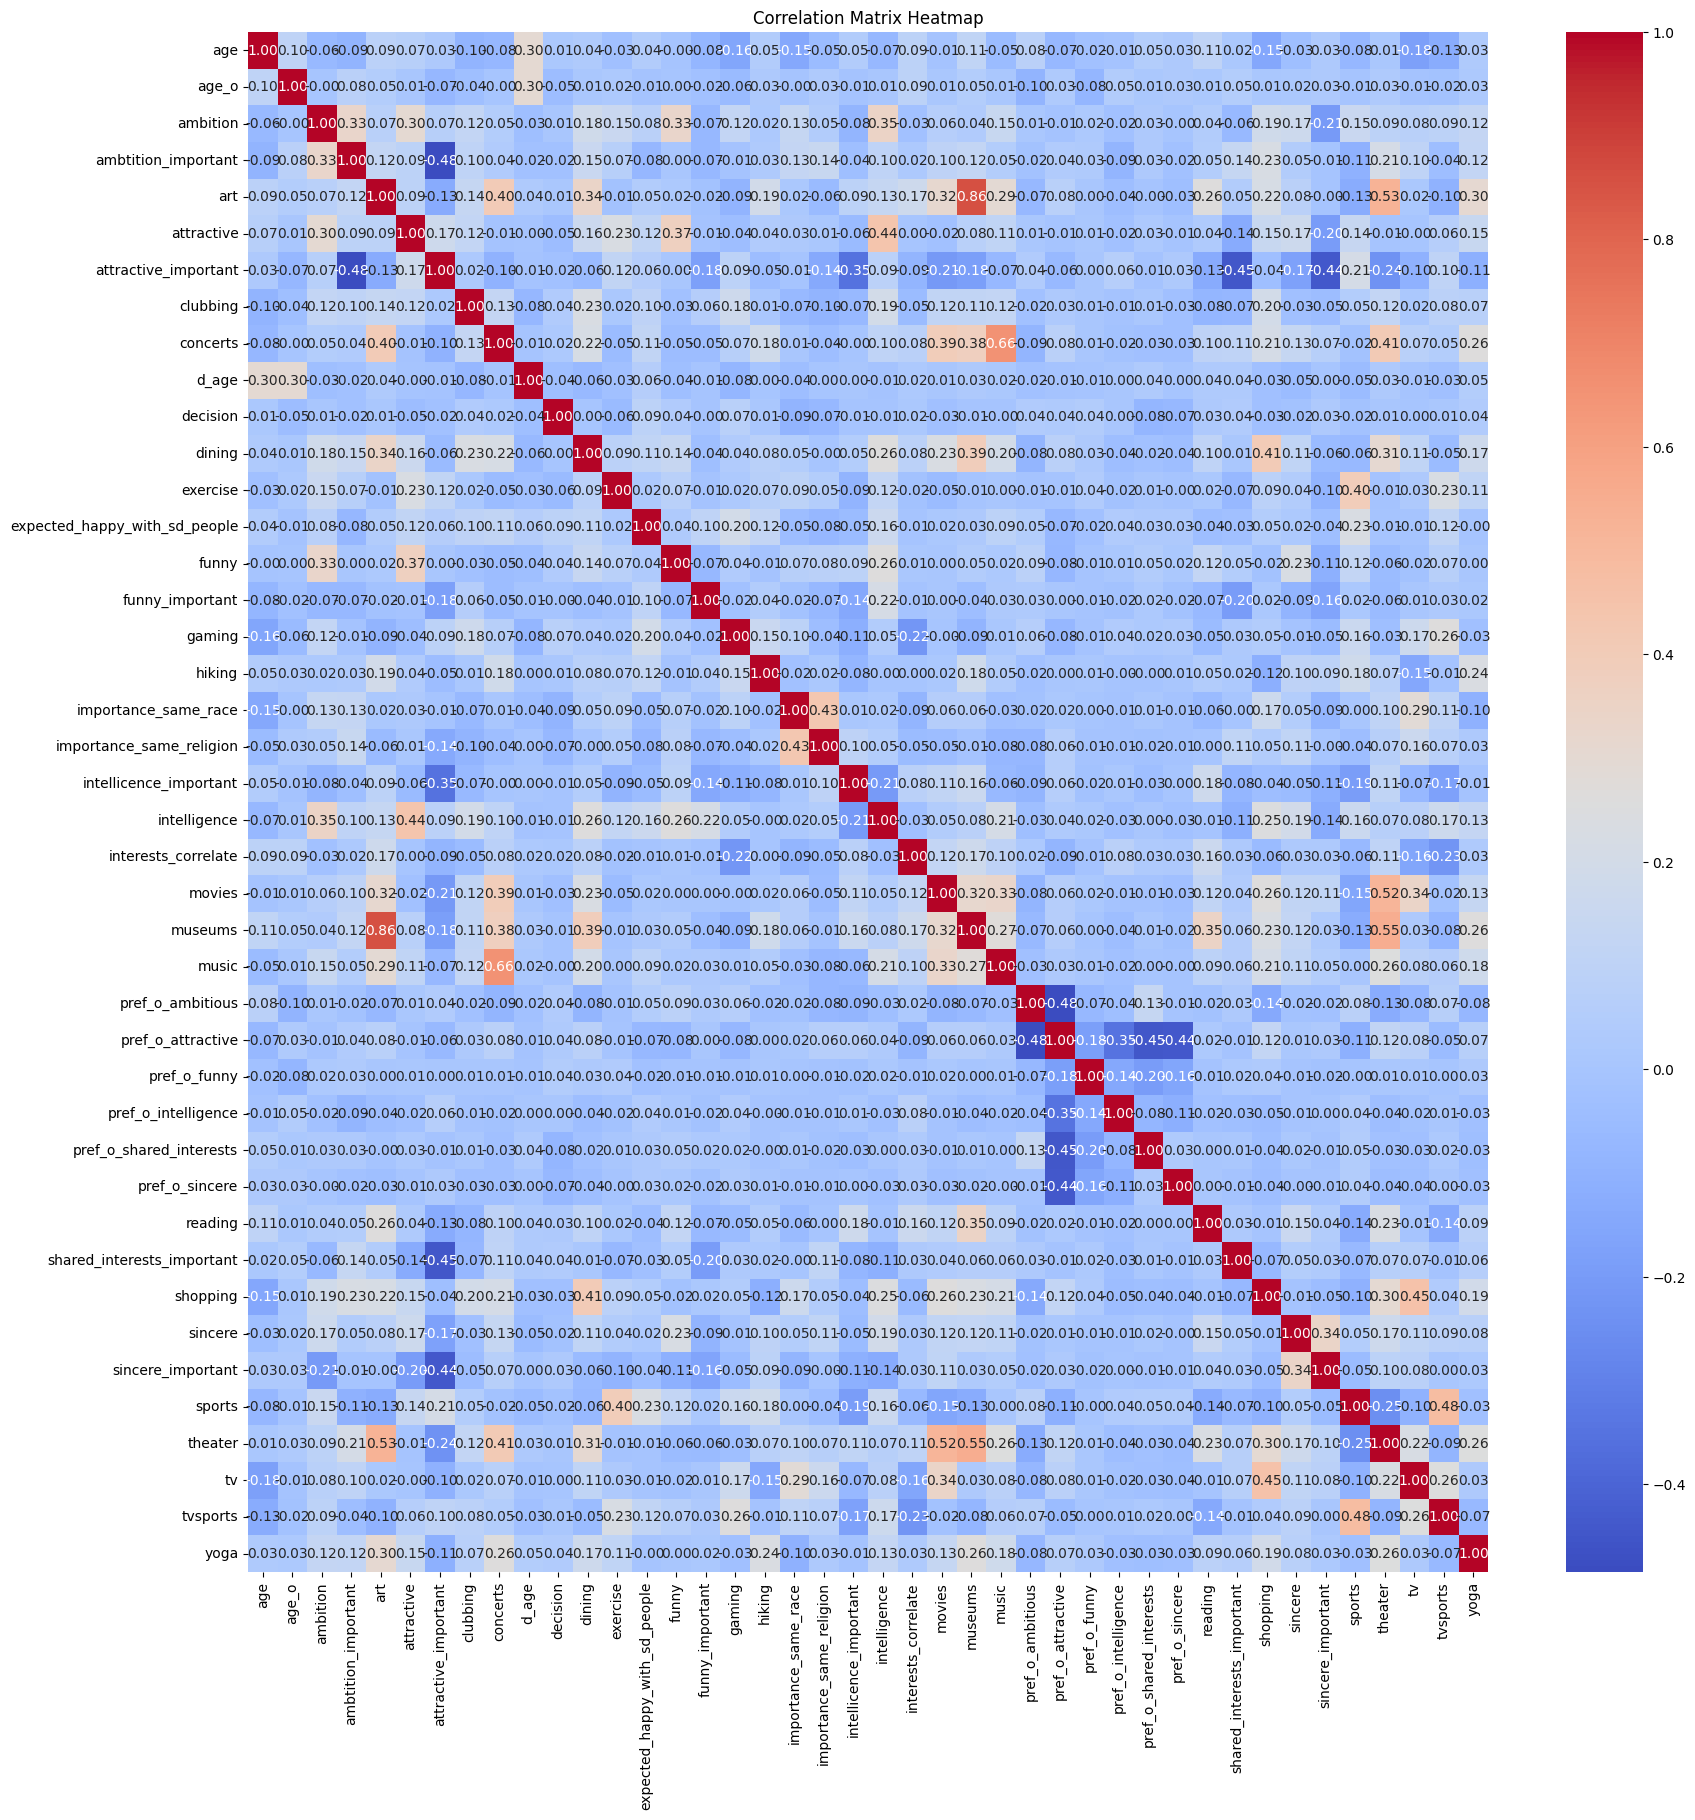


Checking for highly correlated feature pairs (absolute correlation > 0.65):
  - Pair found: 'art' and 'museums' (Correlation: 0.8584)
  - Pair found: 'concerts' and 'music' (Correlation: 0.6555)


In [84]:
# Define categorical columns to exclude them from the correlation analysis.
categorical_features = ['gender', 'race', 'race_o', 'field', 'samerace']

# 1. Isolate the numeric columns for correlation calculation.
numerical_cols = df_imputed_MF.columns.difference(categorical_features)
df_numerical = df_imputed_MF[numerical_cols]

# 2. Calculate the Pearson correlation matrix.
corr_matrix = df_numerical.corr(method='pearson')

# 3. Visualize the correlation matrix with a heatmap.
# WARNING: Setting annot=True with many features can make the plot unreadable and slow to render.
plt.figure(figsize=(20, 20)) # Reduced size slightly
sns.heatmap(
    corr_matrix, 
    annot=True,         # This is the key change to display values in cells
    cmap='coolwarm', 
    fmt=".2f"           # Format values to two decimal places
)
plt.title("Correlation Matrix Heatmap")
plt.show()

# 4. Identify and print pairs of highly correlated features.
threshold = 0.65
found_correlation = False # Flag to check if any pair is found

print(f"\nChecking for highly correlated feature pairs (absolute correlation > {threshold}):")

# Iterate over the upper triangle of the correlation matrix to avoid duplicates.
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # Check if the absolute value of the correlation exceeds the threshold.
        if abs(corr_matrix.iloc[i, j]) > threshold:
            if not found_correlation:
                found_correlation = True # Set flag to true on first find
            
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            
            print(f"  - Pair found: '{colname_j}' and '{colname_i}' (Correlation: {corr_matrix.iloc[i, j]:.4f})")

# Print a final summary message based on the flag.
if not found_correlation:
    print("  - No highly correlated feature pairs were found.")

Looking at the features in the dataset, we expected to find some pairs with high correlation, for example, `art` and `museums`, or `concerts` and `music`. <br>
The correlation matrix does show that these pairs are indeed fairly correlated, but not to a degree that would justify removing one of the two features. So, we decide to leave the dataset unchanged.